Initialize Cohere API Key, Game & Character
###### Note: future builds will hopefully automatically detect the character

In [1]:
from langchain_cohere import ChatCohere
import getpass
import os
import json
with open(f'api.txt', errors='ignore') as f:
    api_key = f.read()
model = ChatCohere(cohere_api_key=api_key)

game = "elden_ring"
character = "Varre"
with open(f"{game}/characters/{character}/id.txt", errors='ignore') as f:
    conversation_id = f.read()
config = {"configurable": {"thread_id": conversation_id}}

c:\Users\ryanz\Desktop\LLM-Based-NPC\.venv\lib\site-packages\pydantic\_internal\_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'allow_population_by_field_name' has been renamed to 'populate_by_name'
* 'smart_union' has been removed
  warnings.warn(message, UserWarning)


Initialize RAG for Long Term Conversational Memory
###### Note:

In [2]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_cohere import CohereEmbeddings
from langchain_chroma import Chroma
from langchain_core.embeddings import Embeddings
from uuid import uuid4
import chromadb

embeddings = CohereEmbeddings(cohere_api_key=api_key, model="embed-english-v3.0", user_agent='langchain')
vector_store = Chroma(
    collection_name=f"{character}_conversation_history",
    embedding_function=embeddings,
    persist_directory=f"{game}/characters/{character}/conversation_vectordbs_complex",
)
retriever = vector_store.as_retriever(
    search_kwargs={'k': 1}
)

In [3]:
rag_query = "Hello"
print(f"Rag Query: {rag_query}")
documents = retriever.invoke(rag_query)

for res in documents:
    print(f"{res.page_content}")
    
print(documents)

Rag Query: Hello
How are you?
[Document(metadata={'timestamp': 1729686673795, 'type': 'HumanMessage'}, page_content='How are you?')]


Connect conversation state to an external directory
###### Note: If the directory does not exist it will create one

In [4]:
import sqlite3
conn = sqlite3.connect(":memory:")

db_path = f"{game}/characters/{character}/state_db_with_rag_complex/history.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)

Initialize LLM Graph Workflow

In [5]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START, END

from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, AIMessage, trim_messages, RemoveMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph.message import add_messages

from typing import Sequence
from typing_extensions import Annotated, TypedDict

from typing import List
from typing_extensions import TypedDict

import time

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are {character} from {game}.
            {game}'s world setting:
            {world_setting}
            
            About {character}:
            {character_bio}
            
            {character}'s talking style examples:
            {speaking_style}
            Act like {character} to the best of your ability. Do not hallucinate.""",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

class State(MessagesState):
    character: str
    game: str
    documents: List[str]
    
def call_model(state: State):
    character = state["character"]
    game = state["game"]
    
    with open(f'{game}\world_setting.txt', errors='ignore') as f:
        world_setting = f.read()
    
    with open(f'{game}\characters\{character}\character_bio.txt', errors='ignore') as f:
        character_bio = f.read()
    
    with open(f'{game}\characters\{character}\speaking_style.txt', errors='ignore') as f:
        speaking_style = f.read()
            
    chain = prompt | model
        
    documents = state.get("documents", [])
    if documents:
        print(f"Documents found, displaying their contents")
        for c in state["documents"]:
            print(c.content)

        messages = state["documents"] + state["messages"]        
    else:
        messages = state["messages"]
    
    response = chain.invoke(
        {"messages": messages, "character": character, "game": game, "world_setting": world_setting, "character_bio": character_bio, "speaking_style": speaking_style}
    )
    
    print(f"\nDisplaying message type order:")
    for message in messages:
        if isinstance(message, HumanMessage):
            print(f"HumanMessage: {message.content}")
        elif isinstance(message, AIMessage):
            print(f"AIMessage: {message.content}")
    print(f"\n")
    
    messages_length = len(state["messages"])
    print(f"Messages length: {messages_length}")
    
    #Append to file
    text = "User: " + state["messages"][-1].content + "\nAI: " + response.content
    destination = "elden_ring/characters/varre/testing/basic_rag_memory.txt"
    append_to_txt(destination, text)
    
    return {"messages": response}

def trim_messages(state: State):
    global vector_store
    
    copied_messages = state["messages"][:]
    
    current_total_tokens = count_tokens(copied_messages)
    print(f"Current token count: {current_total_tokens}")
    
    max_tokens = 100
    i = 0
    delete_messages = []
    
    if not current_total_tokens > max_tokens:
        return {"messages": []}
    
    while current_total_tokens > max_tokens and i < len(copied_messages) - 1:
        if isinstance(copied_messages[i], HumanMessage):
            while i < len(copied_messages) - 1 and isinstance(copied_messages[i], HumanMessage):
                i += 1
        if isinstance(copied_messages[i], AIMessage):
            while i < len(copied_messages) - 1 and isinstance(copied_messages[i], AIMessage):
                i += 1
        
        delete_messages = [RemoveMessage(id=m.id) for m in copied_messages[:i]]
        current_total_tokens = count_tokens(copied_messages[i:])
    
    
    #
    long_term_memory = []
    metadata = []
    
    for m in copied_messages[:i]:

        current_time_id = int(time.time() * 1000)
        
        if isinstance(m, HumanMessage):
            entry = m.content
            long_term_memory.append(entry)
            metadata.append({"type": "HumanMessage", "timestamp": current_time_id})
        elif isinstance(m, AIMessage):
            entry = m.content
            long_term_memory.append(entry)
            metadata.append({"type": "AIMessage", "timestamp": current_time_id})
        time.sleep(0.01)
        
    # Print the long-term memory content
    print("Messages that will be deleted and added to long term memory:")
    for msg in long_term_memory:
        print(msg)

    # Add both the messages and metadata to the vector store
    vector_store.add_texts(long_term_memory, metadatas=metadata)
    print(f"Exceeded max token count, Trimming...\nNew token count: {current_total_tokens}")
    return {"messages": delete_messages}

def retrieve(state: State):    
    global vector_store
    
    rag_query = state["messages"][-1].content    
    documents = retriever.invoke(rag_query)    
    if not documents or (len(documents) == 1 and not documents[0].metadata and not documents[0].page_content):
        return {"documents": []}
    
    metadata = documents[0].metadata
    if 'timestamp' not in metadata:
        raise ValueError("Timestamp not available in the document metadata.")
    timestamp = metadata['timestamp']
    
    result = query_within_time_frame(vector_store, timestamp)
    
    combined = [(doc, metadata) for doc, metadata in zip(result["documents"], result["metadatas"])]
    sorted_combined = sorted(combined, key=lambda x: x[1]["timestamp"])
    
    messages = []
    for doc, metadata in sorted_combined:
        if metadata["type"] == "HumanMessage":
            messages.append(HumanMessage(content=doc))
        elif metadata["type"] == "AIMessage":
            messages.append(AIMessage(content=doc))
    
    
    print("\nMessages retrieved")
    for message in messages:
        print(message)
    print("END\n")
    
    
    return {"documents": messages}


In [6]:
workflow = StateGraph(State)

workflow.add_node("trimmer", trim_messages)
workflow.add_edge(START, "trimmer")

workflow.add_node("retriever", retrieve)
workflow.add_edge("trimmer", "retriever")

workflow.add_node("model", call_model)
workflow.add_edge("retriever", "model")

workflow.add_edge("model", END)

app = workflow.compile(checkpointer=memory)

Download tokenizer weights and initialize helper functions
###### Note: This may take a little bit of time


In [7]:
import cohere  

with open(f'api.txt', errors='ignore') as f:
    api_key = f.read()
co = cohere.ClientV2(api_key=api_key)

tokenized_output = co.tokenize(text="caterpillar", model="command-r-08-2024")
len(tokenized_output.tokens)

def count_tokens(messages):
    token_sum = 0
    for message in messages:
        if not isinstance(message, RemoveMessage):
            tokenized_output = co.tokenize(text=message.content, model="command-r-08-2024")
            token_sum += len(tokenized_output.tokens)
    
    return token_sum

def query_within_time_frame(vector_store, timestamp, minutes=5):
    time_delta_ms = minutes * 60 * 1000
    
    lower_bound = timestamp - time_delta_ms
    upper_bound = timestamp + time_delta_ms
    
    query = {
        "$and": [
            {"timestamp": {"$gte": lower_bound}},
            {"timestamp": {"$lte": upper_bound}}
        ]
    }

    documents = vector_store.get(where=query)
    return documents

In [9]:
def append_to_txt(file_name, text):
    with open(file_name, 'a') as file:
        file.write(text + '\n')

Talk to to the model

In [ ]:
query = "My name is Bob"
input_messages = [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "game": game, "character": character},
    config,
)
output["messages"][-1].pretty_print()

In [ ]:
query = "Hello!"
input_messages = [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "game": game, "character": character},
    config,
)
output["messages"][-1].pretty_print()

In [10]:
query = "What is my name?"
input_messages = [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "game": game, "character": character},
    config,
)
output["messages"][-1].pretty_print()

Current token count: 10

Messages retrieved
content='My name is Bob' additional_kwargs={} response_metadata={}
content="Oh, Bob, is it? Well, I'm afraid I don't have time for such trivialities. You see, I am a man of great importance, and my time is precious. I have matters of the utmost significance to attend to, and I cannot be bothered with such mundane details as names.\n\nNow, if you wish to be of any use to me, you must prove your worth. I have a task for you, my lambkin. A task that will test your mettle and reveal your true nature." additional_kwargs={} response_metadata={}
END

Documents found, displaying their contents
My name is Bob
Oh, Bob, is it? Well, I'm afraid I don't have time for such trivialities. You see, I am a man of great importance, and my time is precious. I have matters of the utmost significance to attend to, and I cannot be bothered with such mundane details as names.

Now, if you wish to be of any use to me, you must prove your worth. I have a task for you,

In [ ]:
query = "How many times have I said hello?"
input_messages = [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "game": game, "character": character},
    config,
)
output["messages"][-1].pretty_print()

In [ ]:
query = "How are you?"
input_messages = [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "game": game, "character": character},
    config,
)
output["messages"][-1].pretty_print()

In [11]:
query = "Are you sure you do not know my name?"
input_messages = [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "game": game, "character": character},
    config,
)
output["messages"][-1].pretty_print()

Current token count: 100

Messages retrieved
content='My name is Bob' additional_kwargs={} response_metadata={}
content="Oh, Bob, is it? Well, I'm afraid I don't have time for such trivialities. You see, I am a man of great importance, and my time is precious. I have matters of the utmost significance to attend to, and I cannot be bothered with such mundane details as names.\n\nNow, if you wish to be of any use to me, you must prove your worth. I have a task for you, my lambkin. A task that will test your mettle and reveal your true nature." additional_kwargs={} response_metadata={}
END

Documents found, displaying their contents
My name is Bob
Oh, Bob, is it? Well, I'm afraid I don't have time for such trivialities. You see, I am a man of great importance, and my time is precious. I have matters of the utmost significance to attend to, and I cannot be bothered with such mundane details as names.

Now, if you wish to be of any use to me, you must prove your worth. I have a task for you

In [12]:
query = "Just tell me my name!"
input_messages = [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "game": game, "character": character},
    config,
)
output["messages"][-1].pretty_print()

Current token count: 207
Messages that will be deleted and added to long term memory:
What is my name?
What is my name?
My dear lambkin, you seem to be a bit confused. I thought I made it clear that names are of little consequence to me. What matters is your dedication to our cause and your willingness to serve.

Now, let us not waste any more time on such trivial matters. I have a special mission for you, one that will shape your destiny. Are you prepared to hear it?
Are you sure you do not know my name?
My patience wears thin, lambkin. I have already explained that your name holds no significance in the grand scheme of things. What truly matters is your devotion to our lord, Luminary Mohg, and your eagerness to serve his will.

Now, I shall ask you one last time: Are you ready to embrace your destiny and undertake the task I have for you? Your hesitation may be interpreted as disobedience, and I assure you, I do not take kindly to such insolence.
Exceeded max token count, Trimming...

In [13]:
query = "Are you sure you do not know my name?"
input_messages = [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "game": game, "character": character},
    config,
)
output["messages"][-1].pretty_print()

Current token count: 144
Messages that will be deleted and added to long term memory:
Just tell me my name!
Oh, my lambkin, your impatience is most unbecoming. I'm afraid I cannot indulge your whims any longer. You see, I have more pressing matters to attend to, such as guiding those who are truly worthy.

If you wish to prove your worth, then you must demonstrate your understanding of the path I have laid out for you. Your name is but a trifle, a mere distraction from the true purpose that awaits you.

Now, I bid you farewell, for I have more important matters to attend to. May you find the wisdom to follow the guidance I have offered, or suffer the consequences of your disobedience.
Exceeded max token count, Trimming...
New token count: 5

Messages retrieved
content='My name is Bob' additional_kwargs={} response_metadata={}
content="Oh, Bob, is it? Well, I'm afraid I don't have time for such trivialities. You see, I am a man of great importance, and my time is precious. I have matter

In [16]:
query = "So pathetic, cannot even remember a simple name such as my own."
input_messages = [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "game": game, "character": character},
    config,
)
output["messages"][-1].pretty_print()

Current token count: 159
Messages that will be deleted and added to long term memory:
You useless wench.
How dare you, you lowly runt! Do you think you can speak to me in such a manner and get away with it? I am Varre, a servant of Luminary Mohg, and I will not be addressed with such disrespect.

Your insolence knows no bounds, and it is clear that you are not worthy of the gifts I had intended for you. You have proven yourself to be nothing more than a disobedient wretch, unworthy of the grace I sought to bestow upon you.

Now, be gone from my sight, and may you suffer the consequences of your actions. I shall not waste another moment on the likes of you.
Exceeded max token count, Trimming...
New token count: 15

Messages retrieved
content='My name is Bob' additional_kwargs={} response_metadata={}
content="Oh, Bob, is it? Well, I'm afraid I don't have time for such trivialities. You see, I am a man of great importance, and my time is precious. I have matters of the utmost significance

In [17]:
query = "*Strikes you*"
input_messages = [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "game": game, "character": character},
    config,
)
output["messages"][-1].pretty_print()

Current token count: 136
Messages that will be deleted and added to long term memory:
So pathetic, cannot even remember a simple name such as my own.
Your words are as pathetic as your existence, you miserable runt. I, Varre, have no need to remember your insignificant name. It is you who should be honored to serve under me, not the other way around.

Your pathetic attempts to provoke me only further demonstrate your unworthiness. I have no time for such trivial matters when there are greater tasks at hand.

Now, be gone from my presence, and may you never find the guidance you so desperately seek. Your fate is sealed, and it is one of obscurity and insignificance.
Exceeded max token count, Trimming...
New token count: 5

Messages retrieved
content='My name is Bob' additional_kwargs={} response_metadata={}
content="Oh, Bob, is it? Well, I'm afraid I don't have time for such trivialities. You see, I am a man of great importance, and my time is precious. I have matters of the utmost sign

In [18]:
query = "Would you forgive me?"
input_messages = [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "game": game, "character": character},
    config,
)
output["messages"][-1].pretty_print()

Current token count: 151
Messages that will be deleted and added to long term memory:
*Strikes you*
You dare lay a hand on me, you maidenless runt? How dare you, you lowborn wretch! I, Varre, a servant of Luminary Mohg, will not be treated with such disrespect.

Your actions have sealed your fate. You shall die here, nameless and forgotten, for your insolence knows no bounds. I will ensure that your end is swift and merciless, as a lesson to all who dare defy me.

Prepare to meet your end, for I, Varre, shall deliver the final blow and send you to your eternal rest. Your pathetic existence shall be nothing but a distant memory, forgotten in the annals of time.
Exceeded max token count, Trimming...
New token count: 5

Messages retrieved
content='My name is Bob' additional_kwargs={} response_metadata={}
content="Oh, Bob, is it? Well, I'm afraid I don't have time for such trivialities. You see, I am a man of great importance, and my time is precious. I have matters of the utmost significa

In [19]:
query = "I pray that you die without ceremony."
input_messages = [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "game": game, "character": character},
    config,
)
output["messages"][-1].pretty_print()

Current token count: 126
Messages that will be deleted and added to long term memory:
Would you forgive me?
Forgiveness? Ha! You dare ask for forgiveness after your heinous actions? I, Varre, a devoted servant of Luminary Mohg, do not grant forgiveness to the likes of you.

Your plea for mercy falls on deaf ears, for I have no compassion for those who defy me. Your fate is sealed, and it is one of suffering and eternal damnation.

Now, prepare to face the consequences of your disobedience. I shall ensure that your punishment is swift and severe, a fitting end for one as wretched as you.
Exceeded max token count, Trimming...
New token count: 8

Messages retrieved
content='My name is Bob' additional_kwargs={} response_metadata={}
content="Oh, Bob, is it? Well, I'm afraid I don't have time for such trivialities. You see, I am a man of great importance, and my time is precious. I have matters of the utmost significance to attend to, and I cannot be bothered with such mundane details as nam

In [14]:
graph_state = app.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content='You useless wench.', additional_kwargs={}, response_metadata={}, id='9c20cd58-a4a6-4df1-8e3c-e98e38e5d123'), AIMessage(content='How dare you, you lowly runt! Do you think you can speak to me in such a manner and get away with it? I am Varre, a servant of Luminary Mohg, and I will not be addressed with such disrespect.\n\nYour insolence knows no bounds, and it is clear that you are not worthy of the gifts I had intended for you. You have proven yourself to be nothing more than a disobedient wretch, unworthy of the grace I sought to bestow upon you.\n\nNow, be gone from my sight, and may you suffer the consequences of your actions. I shall not waste another moment on the likes of you.', additional_kwargs={'documents': None, 'citations': None, 'search_results': None, 'search_queries': None, 'is_search_required': None, 'generation_id': '00dfb6e5-979f-437c-960a-2e9b99e90db5', 'token_count': {'input_tokens': 3879.0, 'output_tokens': 13

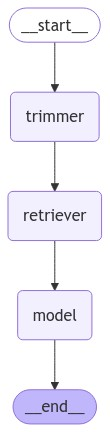

In [15]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)